In this Notebook we will attempt to predict the dynamics of the second COVID-19 wave in Belgium at the level of arrondissements, based on ...
- Expectation values of all calibrated parameters except $\beta^R$, $\beta^U$ and $\beta^M$, calibrated on the entire first wave
- Calibrated values of parameters $\beta^R$, $\beta^U$, and $\beta^M$ (and `warmup`), calibrated on the ascending part of the second wave
- Initial condition for all states, based on calibration on first wave.
- Knowledge of the timing and severity of non-pharmaceutical measures in the near future
- Uncertainties in the first-wave parameter values (from previous calibration), and uncertainties in the second-wave parameter values (from new calibration)

**Some side notes (criticism)**
- The expectation values of each parameter do *not* correspond to the same run

In [3]:
# Preamble
import corner
import pandas as pd
import json
import numpy as np
from IPython.display import IFrame
import matplotlib.pyplot as plt

from covid19model.models import models
from covid19model.models.time_dependant_parameter_fncs import make_mobility_update_function, make_contact_matrix_function
from covid19model.models.utils import initial_state
# from covid19model.optimization.run_optimization import checkplots, calculate_R0
# from covid19model.optimization.objective_fcns import prior_custom, prior_uniform
from covid19model.data import mobility, sciensano, model_parameters
# from covid19model.optimization import pso, objective_fcns
from covid19model.visualization.output import _apply_tick_locator 
from covid19model.visualization.optimization import autocorrelation_plot, traceplot, plot_fit, plot_calibration_fit
from covid19model.visualization.utils import moving_avg
from covid19model.optimization.utils import perturbate_PSO, run_MCMC
from covid19model.optimization.utils import samples_dict_to_emcee_chain # used for corner plots
import random
import datetime

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
# This may be useful because the `covid19model` package is under construction
%autoreload 2

# Copied from mrollier-calibration-WAVE2_spatial.ipynb
import gc
import sys, getopt
import os
import ujson as json
import random
import emcee
import datetime
import corner
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing as mp
from multiprocessing import Pool

from covid19model.models import models
from covid19model.optimization.objective_fcns import prior_custom, prior_uniform
from covid19model.data import mobility, sciensano, model_parameters
from covid19model.optimization import pso, objective_fcns
from covid19model.models.time_dependant_parameter_fncs import ramp_fun
from covid19model.visualization.output import _apply_tick_locator 
from covid19model.visualization.optimization import autocorrelation_plot, traceplot
from covid19model.models.utils import initial_state

spatial='arr'

# Calibrate transmission coefficients over ascending part

In [8]:
# Choose to show progress bar. This cannot be shown on HPC
progress = True

# User-defined initial states json file
initial_states_date = '2020-08-27'
initial_states_loc = '../../data/interim/model_parameters/COVID19_SEIRD/calibrations/arr'
# arr_WAVE1_job-FULL_1000xPSO_20000xMCMC_arr_3-index-in-frac_2021-06-10_states_2020-08-27_fiddling-08aug21.json
initial_states_json = f'arr_WAVE1_job-FULL_1000xPSO_20000xMCMC_arr_3-index-in-frac_2021-06-10_states_{initial_states_date}_fiddling-08aug21.json'

In [9]:
backend = None # None or True
job = 'R0' # R0 or FULL
warmup = None # warmup must be defined if job == FULL 
maxiter_PSO = 200 # 50 # defaults is 50 (which isn't much)
maxn_MCMC = 1000 # default is 100 (which isn't much)
signature = 'predict-wave2-from-wave1_new-init-states'
agg = spatial

# Date at which script is started
run_date = str(datetime.date.today())

In [10]:
# ---------
# Load data
# ---------

# Time-integrated contact matrices
initN, Nc_all = model_parameters.get_integrated_willem2012_interaction_matrices(spatial=agg)
G, N = initN.shape
# Sciensano spatially stratified data
moving_avg=False
df_sciensano = sciensano.get_sciensano_COVID19_data_spatial(agg=agg, values='hospitalised_IN', moving_avg=moving_avg)
# Google Mobility data
df_google = mobility.get_google_mobility_data(update=False)
# Load and format mobility dataframe
proximus_mobility_data, proximus_mobility_data_avg = mobility.get_proximus_mobility_data(agg, dtype='fractional', beyond_borders=False)

In [11]:
# ------------------------
# Define results locations
# ------------------------

# Path where traceplot and autocorrelation figures should be stored.
# This directory is split up further into autocorrelation, traceplots
fig_path = f'../../results/calibrations/COVID19_SEIRD/{agg}/'
# Path where MCMC samples should be saved
samples_path = f'../../data/interim/model_parameters/COVID19_SEIRD/calibrations/{agg}/'
# Path where samples backend should be stored
backend_folder = f'../../results/calibrations/COVID19_SEIRD/{agg}/backends/'

# Verify that these paths exists
if not (os.path.exists(fig_path) and os.path.exists(samples_path) and os.path.exists(backend_folder)):
    raise Exception("Some of the results location directories do not exist.")

# Verify that the fig_path subdirectories used in the code exist
if not (os.path.exists(fig_path+"autocorrelation/") and os.path.exists(fig_path+"traceplots/") \
       and os.path.exists(fig_path+"pso/")):
    raise Exception(f"The directory {fig_path} should have subdirectories 'autocorrelation', 'traceplots' and 'pso'.")

In [12]:
# -----------------------
# Define helper functions
# -----------------------

from covid19model.optimization.utils import assign_PSO, plot_PSO, perturbate_PSO, run_MCMC

In [13]:
# ------------------------------------------------------
# Define time-dependant parameter functions from classes
# ------------------------------------------------------

# Load both classes
from covid19model.models.time_dependant_parameter_fncs import make_contact_matrix_function, make_mobility_update_function

### ATTENTION ###

# Define contact matrix functions based on 4 prevention parameters (effectivity parameters)
policies_WAVE2_full_relaxation = make_contact_matrix_function(df_google, Nc_all).policies_WAVE2_full_relaxation # with delayed-ramp function

# Mobility update function from class __call__ and function wrapper to get the right signature
mobility_wrapper_function = make_mobility_update_function(proximus_mobility_data, proximus_mobility_data_avg).mobility_wrapper_func

In [20]:
# ---------------------
# Load model parameters ... from WAVE1 data (taken from corner plots)
# ---------------------

### ATTENTION ###

# Load the model parameters dictionary
params = model_parameters.get_COVID19_SEIRD_parameters(spatial=agg, VOC=False)
# Add the time-dependant parameter function arguments
# Copy best-fit values from MR-postprocessing-calibration.ipynb
# Note how these parameters do not affect the calibration, because we are only looking at the ascending part
params.update({'l' : 8.23,
               'prev_schools': 1.0, # was not calibrated because schools were closed all the time
               'prev_work': 0.651,
               'prev_rest': 0.00786,
               'prev_home' : 0.446,
               'relaxdate' : '2021-07-01', # new parameter, only relevant for 2021
               'l_relax' : 31 # new parameter, only relevant for 2021
              })
# Add parameters for the daily update of proximus mobility
# mobility defaults to average mobility of 2020 if no data is available
params.update({'default_mobility' : None})

In [21]:
# --------------------
# Model initialisation
# --------------------

# Model initial condition on September 1st
# This contains a dict with all states, and values for these states per age
# This needs to be modified in such a way that we have the output per region as well
with open(f'{initial_states_loc}/{initial_states_json}', 'r') as fp:
    initial_states = json.load(fp) 

# Initiate model with initial states, defined parameters, and proper time dependent functions
model = models.COVID19_SEIRD_spatial(initial_states, params, time_dependent_parameters = \
                                           {'Nc' : policies_WAVE2_full_relaxation, 'place' : mobility_wrapper_function}, spatial=agg)

Let's say the government is getting worried again early September, and gathers data until October, which is when a decision is to be made on how to act.


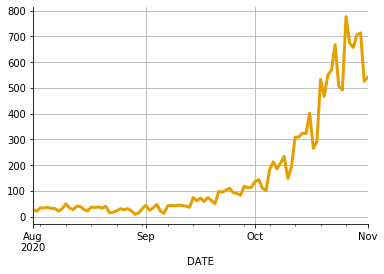

In [10]:
# Check the time series data and decide on a natural reference point, e.g. one full month of data
df_sciensano.sum(axis=1)['2020-08-01':'2020-11-01'].plot()

print("Let's say the government is getting worried again early September, and gathers data until October, which is when a decision is to be made on how to act.")

In [11]:
# ------------------
# Calibration set-up
# ------------------

# Start data of recalibration ramp
start_calibration = '2020-09-01'
# Last datapoint used to calibrate warmup and beta
end_calibration = '2020-10-01' # date of lockdown

# Spatial unit: depends on aggregation
spatial_unit = f'{agg}_WAVE2-{job}_{signature}'

# PSO settings
processes = int(os.getenv('SLURM_CPUS_ON_NODE', mp.cpu_count()))
sys.stdout.flush()
multiplier = 10
maxiter = maxiter_PSO
popsize = multiplier*processes

# MCMC settings
max_n = maxn_MCMC
print_n = 100

# Offset needed to deal with zeros in data in a Poisson distribution-based calibration
poisson_offset = 1

In [12]:
# -------------------------
# Print statement to stdout
# -------------------------

print('\n------------------------------------------')
print('PERFORMING CALIBRATION OF WARMUP and BETAs')
print('------------------------------------------\n')
print('Using data from '+start_calibration+' until '+end_calibration+'\n')
print('1) Particle swarm optimization')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')
print(f'Using {str(processes)} cores for a population of {popsize}, for maximally {maxiter} iterations.\n')
sys.stdout.flush()


------------------------------------------
PERFORMING CALIBRATION OF WARMUP and BETAs
------------------------------------------

Using data from 2020-09-01 until 2020-10-01

1) Particle swarm optimization
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Using 12 cores for a population of 120, for maximally 200 iterations.



In [13]:
# --------------
# define dataset
# --------------

# Only use hospitalisation data
data=[df_sciensano[start_calibration:end_calibration]]
states = ["H_in"]
weights = [1]

In [14]:
# NOTE: I changed the boundaries

# -----------
# Perform PSO
# -----------

# set optimisation settings
# NOTE: the initial states are from August 27th, so the warmup time should be the number of days
# between August 27th and September 1st, i.e. 5.
pars = ['warmup','beta_R', 'beta_U', 'beta_M']
bounds=((0.0,10.0),(0.005,0.060), (0.005,0.060), (0.005,0.060))

# run optimisation
theta = pso.fit_pso(model, data, pars, states, bounds, weights=weights, maxiter=maxiter, popsize=popsize, dist='poisson',
                    poisson_offset=poisson_offset, agg=agg, start_date=start_calibration, processes=processes)
# Fill in line below if you want to skip PSO
# theta = np.array([48, 0.01896, 0.02153, 0.02599])
# Assign estimate.
warmup, pars_PSO = assign_PSO(model.parameters, pars, theta)
model.parameters = pars_PSO

# Perform simulation with best-fit results
out = model.sim(end_calibration,start_date=start_calibration,warmup=warmup)

# Print statement to stdout once
print(f'\nPSO RESULTS:')
print(f'------------')
print(f'warmup: {warmup}')
print(f'infectivities {pars[1:]}: {theta[1:]}.')
sys.stdout.flush()

No constraints given.
Best after iteration 1: [9.81632326e+00 1.16287783e-02 9.11584235e-03 1.74463238e-02] -626.8381912619271
Best after iteration 2: [9.81632326e+00 1.16287783e-02 9.11584235e-03 1.74463238e-02] -626.8381912619271
New best for swarm at iteration 3: [8.41610069 0.01656524 0.01100334 0.01692336] -684.54664914756
Best after iteration 3: [8.41610069 0.01656524 0.01100334 0.01692336] -684.54664914756
Best after iteration 4: [8.41610069 0.01656524 0.01100334 0.01692336] -684.54664914756
New best for swarm at iteration 5: [1.00000000e+01 5.00000000e-03 1.43893966e-02 1.78750651e-02] -762.7211134495553
Best after iteration 5: [1.00000000e+01 5.00000000e-03 1.43893966e-02 1.78750651e-02] -762.7211134495553
New best for swarm at iteration 6: [1.00000000e+01 8.59022552e-03 1.22286314e-02 1.85004822e-02] -797.7590862193107
Best after iteration 6: [1.00000000e+01 8.59022552e-03 1.22286314e-02 1.85004822e-02] -797.7590862193107
Best after iteration 7: [1.00000000e+01 8.59022552e-03

KeyboardInterrupt: 

In [ ]:
# Visualize fit and save in order to check the validity of the first step
ax = plot_PSO(out, theta, pars, data, states, pd.to_datetime(start_calibration), pd.to_datetime(end_calibration))
title=f'warmup: {round(warmup)}; {pars[1:]}: {[round(th,3) for th in theta[1:]]}.'
ax.set_title(title)
ax.set_ylabel('New national hosp./day')
pso_figname = f'{spatial_unit}_PSO-fit_{run_date}'
# plt.savefig(f'{fig_path}/pso/{pso_figname}.png',dpi=400, bbox_inches='tight')
print(f'\nSaved figure /pso/{pso_figname}.png with results of calibration for job==R0.\n')
sys.stdout.flush()
# plt.close()

In [ ]:
# ------------------
# Setup MCMC sampler
# ------------------

# Define priors
log_prior_fcn = [prior_uniform, prior_uniform, prior_uniform]
log_prior_fcn_args = bounds[1:]
# Perturbate PSO estimate
pars = ['beta_R', 'beta_U', 'beta_M']
pert = [0.02, 0.02, 0.02]
ndim, nwalkers, pos = perturbate_PSO(theta[1:], pert, multiplier=processes, bounds=log_prior_fcn_args, verbose=False)

# Set up the sampler backend if needed
if backend:
    filename = f'{spatial_unit}_backend_{run_date}'
    backend = emcee.backends.HDFBackend(results_folder+filename)
    backend.reset(nwalkers, ndim)

# Labels for traceplots
labels = ['$\\beta_R$', '$\\beta_U$', '$\\beta_M$']
# Arguments of chosen objective function
objective_fcn = objective_fcns.log_probability
objective_fcn_args = (model, log_prior_fcn, log_prior_fcn_args, data, states, pars)
objective_fcn_kwargs = {'weights':weights, 'draw_fcn':None, 'samples':{}, 'start_date':start_calibration, \
                        'warmup':warmup, 'dist':'poisson', 'poisson_offset':poisson_offset, 'agg':agg}

In [ ]:
print('\n2) Markov-Chain Monte-Carlo sampling')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')
print(f'Using {processes} cores for {ndim} parameters, in {nwalkers} chains.\n')
sys.stdout.flush()


# ----------------
# Run MCMC sampler
# ----------------

# Print autocorrelation and traceplot every print_n'th iteration
sampler = run_MCMC(pos, max_n, print_n, labels, objective_fcn, objective_fcn_args, \
                   objective_fcn_kwargs, backend, spatial_unit, run_date, job, progress=progress, agg=agg)

In [ ]:
# ---------------
# Process results
# ---------------

thin = 1
try:
    autocorr = sampler.get_autocorr_time()
    thin = max(1,int(0.5 * np.min(autocorr)))
    print(f'Convergence: the chain is longer than 50 times the intergrated autocorrelation time.\nPreparing to save samples with thinning value {thin}.')
    sys.stdout.flush()
except:
    print('Warning: The chain is shorter than 50 times the integrated autocorrelation time.\nUse this estimate with caution and run a longer chain! Saving all samples (thinning=1).\n')
    sys.stdout.flush()

In [ ]:
print('\n3) Sending samples to dictionary')
sys.stdout.flush()

flat_samples = sampler.get_chain(discard=0,thin=thin,flat=True)
samples_dict = {}
for count,name in enumerate(pars):
    samples_dict[name] = flat_samples[:,count].tolist()

samples_dict.update({
    'warmup' : warmup,
    'start_date_R0' : start_calibration,
    'end_date_R0' : end_calibration,
    'n_chains_R0': int(nwalkers)
})

json_file = f'{samples_path}{str(spatial_unit)}_{run_date}.json'
with open(json_file, 'w') as fp:
    json.dump(samples_dict, fp)

print('DONE!')
print(f'SAMPLES DICTIONARY SAVED IN "{json_file}"')
print('-------------------------------------------------------------------------------------------------------------------------------\n')
sys.stdout.flush()

# Make predictions for future of the 2nd wave

We will be loading a hybrid data set: (1) calibrated parameter values for the `beta` values from the ascending part of the 2nd wave, and (2) calibrated parameter values for the data associated with 'lockdown', used to predict the future.

User-defined data (i.e. defined by politicians) include date and severity of non-pharmaceutical interventions.

Based on Notebook `MR-postprocessing-calibration.ipynb`

## Show cornerplot of results of calibration of ascending part of wave 2

In [4]:
##################
### USER INPUT ###
##################

# can take a while

# Simulation properties
agg = 'arr'
job = 'R0'
maxiter = 50
number = 100
date = '2021-08-05' # Date of calibration execution

moving_avg = False

###################

# Automated name
# arr_WAVE2-R0_predict-wave2-from-wave1_2021-08-04
json_name = f"{agg}_WAVE2-{job}_predict-wave2-from-wave1_new-init-states_{date}.json"
json_loc = f"../../data/interim/model_parameters/COVID19_SEIRD/calibrations/{agg}"

# Load dict and thin/discard
samples_dict = json.load(open(f'{json_loc}/{json_name}'))
parNames_mcmc = ['beta_R', 'beta_U', 'beta_M']
labels = ['$\\beta^R$', '$\\beta^U$', '$\\beta^M$']
if job == 'FULL':
    parNames_mcmc += ['l', 'prev_schools', 'prev_work', 'prev_rest', 'prev_home']
    labels += ['$l$', '$\Omega^{schools}$', '$\Omega^{work}$', '$\Omega^{rest}$', '$\Omega^{home}$']
nwalkers=int(samples_dict[f'n_chains_{job}'])
discard=0
thin=1
samples,flat_samples = samples_dict_to_emcee_chain(samples_dict, parNames_mcmc, nwalkers, discard=discard, thin=thin)

samples_dict.keys()

# arr_WAVE2-R0_predict-wave2-from-wave1_new-init-states_2021-08-05.json

dict_keys(['beta_R', 'beta_U', 'beta_M', 'warmup', 'start_date_R0', 'end_date_R0', 'n_chains_R0'])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


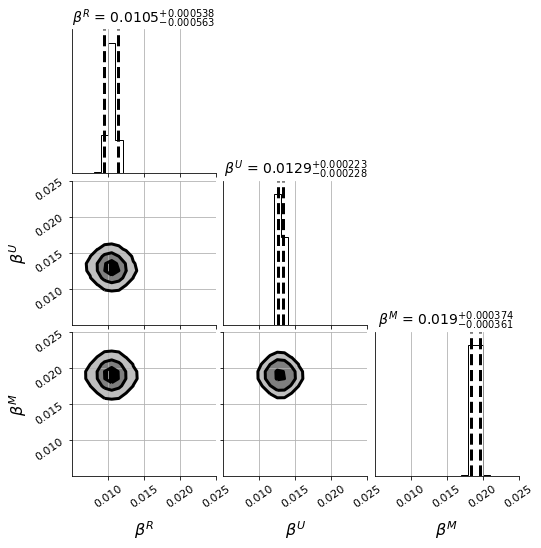

In [5]:
CORNER_KWARGS = dict(
    smooth=0.9,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=14),
    quantiles=[0.0455, 0.9545],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_density=True,
    plot_datapoints=False,
    fill_contours=True,
    show_titles=True,
    max_n_ticks=4,
    title_fmt=".3",
    range=[(0.005, 0.025), (0.005, 0.025), (0.005, 0.025)]
)
    # range=[(0.01425, 0.01500), (0.01395, 0.0144), (0.01525, 0.01600), (0.0, 4.0), (0.85, 1.0), (0.0, 0.75), (0.0, 0.2),(0.6,1.0)]
    # range=[(0.02075, 0.02150), (0.02080, 0.02120), (0.02200, 0.02275), (7.2, 9.1), (0.3, 0.9), (0.0, 0.06), (0.25, 0.75)]

# Cornerplots of samples
fig = corner.corner(flat_samples, labels=labels, **CORNER_KWARGS)

for idx,ax in enumerate(fig.get_axes()):
    ax.tick_params(axis='both', labelsize=11, rotation=35)

# Save figure
fig.show()
savename = f'../../results/calibrations/COVID19_SEIRD/arr/cornerplots/{json_name[:-5]}_CORNER.png'
# fig.savefig(savename_WAVE2, dpi=400, bbox_inches='tight')
# plt.close()

## Fit to existing data and mock prediction

Copied from `MR-postprocessing-calibration.ipynb`. Much of this is already loaded earlier

NOTE: When creating the fit plots, samples are taken from a 'raw' dictionary, i.e. a dictionary that is not flattened (thin and discard). Why would you do this? I suppose this is a mistake.

NOTE: these simulations depend on the definition of the social policy function defined in `policies_WAVE2_full_prediction`. Note how we added `SB='2a'`, which indicates that we take the average social behaviour in September, which is also the period we used to calibrate over. Also, we do not know the mobility patterns of the future, so we will also rely on the average mobility in September.

### Redefine time-dependent social contact

In [6]:
# COPY DEFINITION OF POLICIES RIGHT AFTER 

def contact_matrix(t, prev_home=1, prev_schools=1, prev_work=1, prev_rest = 1,
                   school=None, work=None, transport=None, leisure=None, others=None, home=None, SB=False):

    """
    t : timestamp
        current date
    prev_... : float [0,1]
        prevention parameter to estimate
    school, work, transport, leisure, others : float [0,1]
        level of opening of these sectors
        if None, it is calculated from google mobility data
        only school cannot be None!
    SB : str '2a', '2b' or '2c'
        '2a': september behaviour overall
        '2b': september behaviour, but work = lockdown behaviour
        '2c': september behaviour, but leisure = lockdown behaviour

    """

    if t < pd.Timestamp('2020-03-15'):
        CM = Nc_all['total']
    else:

        if school is None:
            raise ValueError(
            "Please indicate to which extent schools are open")

        if pd.Timestamp('2020-03-15') <= t <= df_google.index[-1]:
            #take t.date() because t can be more than a date! (e.g. when tau_days is added)
            idx = int((t - df_google.index[0]) / pd.Timedelta("1 day"))
            row = -df_google.values[idx]/100
        else:
            row = -df_google[-7:-1].mean()/100 # Extrapolate mean of last week

        if SB == '2a':
            row = -df_google['2020-09-01':'2020-10-01'].mean()/100
        elif SB == '2b':
            row = -df_google['2020-09-01':'2020-10-01'].mean()/100
            row[4] = -df_google['2020-03-15':'2020-04-01'].mean()[4]/100
        elif SB == '2c':
            row = -df_google['2020-09-01':'2020-10-01'].mean()/100
            row[0] = -df_google['2020-03-15':'2020-04-01'].mean()[0]/100

        # columns: retail_recreation grocery parks transport work residential
        if work is None:
            work= 1-row[4]
        if transport is None:
            transport=1-row[3]
        if leisure is None:
            leisure=1-row[0]
        if others is None:
            others=1-row[1]

        CM = (prev_home*Nc_all['home'] +
              prev_schools*school*Nc_all['schools'] +
              prev_work*work*Nc_all['work'] +
              prev_rest*transport*Nc_all['transport'] +
              prev_rest*leisure*Nc_all['leisure'] +
              prev_rest*others*Nc_all['others'])

    return CM

def ramp_fun(Nc_old, Nc_new, t, t_start, l):
    """
    t : timestamp
        current simulation time
    t_start : timestamp
        start of policy change
    l : int
        number of additional days after the time delay until full compliance is reached
    """
    return Nc_old + (Nc_new-Nc_old)/l * (t-t_start)/pd.Timedelta('1D')

def policies_WAVE2_prediction(t, states, param, l , l_relax, prev_schools, prev_work, prev_rest, prev_home, relaxdate):
    '''
    Function that returns the time-dependant social contact matrix Nc for the second 2020 COVID-19 wave. Includes a full relaxation of measures on relaxdate.

    Input
    -----
    t : Timestamp
        simulation time
    states : xarray
        model states
    param : dict
        model parameter dictionary
    l : float
        Compliance parameter for ramp_fun
    l_relax : float
        Additional days added after relaxdate
    tau : float
        Compliance parameter for ramp_fun
    prev_{location} : float
        Effectivity of contacts at {location}
    relaxdate : str
        String containing a date (YYYY-MM-DD) on which all measures are relaxed

    Returns
    -------
    CM : np.array (9x9)
        Effective contact matrix (output of __call__ function)
    '''
    t = pd.Timestamp(t.date())

    # Convert compliance tau and l to dates
    l_days = pd.Timedelta(l, unit='D')

    # Convert relaxation l to dates
    l_relax_days = pd.Timedelta(l_relax, unit='D')

    # Define key dates of first wave
    t1 = pd.Timestamp('2020-03-15') # start of lockdown
    t2 = pd.Timestamp('2020-05-15') # gradual re-opening of schools (assume 50% of nominal scenario)
    t3 = pd.Timestamp('2020-07-01') # start of summer holidays
    t4 = pd.Timestamp('2020-09-01') # end of summer holidays

    # Define key dates of second wave
    # Note that for days in the future, policies are estimated rather than observed
    
    ### THIS IS USER-DEFINED AND DETERMINES THE POLICIES IN OCTOBER/NOVEMBER
    ########################################################################
    t5 = pd.Timestamp('2020-10-19') # lockdown (1)
    t6 = pd.Timestamp('2020-11-02') # lockdown (2)
    t7 = pd.Timestamp('2020-11-16') # schools re-open
    t8 = pd.Timestamp('2020-12-18') # Christmas holiday starts
    t9 = pd.Timestamp('2021-01-04') # Christmas holiday ends
    t10 = pd.Timestamp('2021-02-15') # Spring break starts
    t11 = pd.Timestamp('2021-02-21') # Spring break ends
    t12 = pd.Timestamp('2021-02-28') # Contact increase in children
    t13 = pd.Timestamp('2021-03-26') # Start of Easter holiday
    t14 = pd.Timestamp('2021-04-18') # End of Easter holiday
    t15 = pd.Timestamp(relaxdate) # Relaxation date
    t16 = pd.Timestamp('2021-07-01') # Start of Summer holiday
    t17 = pd.Timestamp('2021-09-01')
    ########################################################################

    # Second wave
    
    ### THIS IS USER-DEFINED AND DETERMINES THE POLICIES IN OCTOBER/NOVEMBER
    ########################################################################
    if t4 < t <= t5:
        return contact_matrix(t, school=1)
    elif t5  < t <= t5 + l_days:
        policy_old = contact_matrix(t, school=1, SB='2a')
        policy_new = contact_matrix(t, prev_schools, prev_work, prev_rest, 
                                    school=1, SB='2a')
        return ramp_fun(policy_old, policy_new, t, t5, l)
    elif t5 + l_days < t <= t6:
        return contact_matrix(t, prev_home, prev_schools, prev_work, prev_rest, 
                            school=1, SB='2a')
    elif t6 < t <= t7:
        return contact_matrix(t, prev_home, prev_schools, prev_work, prev_rest, 
                            school=0, SB='2a')
    ########################################################################
    elif t7 < t <= t8:
        return contact_matrix(t, prev_home, prev_schools, prev_work, prev_rest, 
                            school=1) 
    elif t8 < t <= t9:
        return contact_matrix(t, prev_home, prev_schools, prev_work, prev_rest, 
                            school=0)
    elif t9 < t <= t10:
        return contact_matrix(t, prev_home, prev_schools, prev_work, prev_rest, 
                            school=1)
    elif t10 < t <= t11:
        return contact_matrix(t, prev_home, prev_schools, prev_work, prev_rest, 
                            school=0)    
    elif t11 < t <= t12:
        return contact_matrix(t, prev_home, prev_schools, prev_work, prev_rest, 
                            school=1)
    elif t12 < t <= t13:
        return contact_matrix(t, prev_home, prev_schools, prev_work, prev_rest,
                            school=1)
    elif t13 < t <= t14:
        return contact_matrix(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0)                           
    elif t14 < t <= t15:
        return contact_matrix(t, prev_home, prev_schools, prev_work, prev_rest, 
                            school=1)   
    elif t15 < t <= t15 + l_relax_days:
        policy_old = contact_matrix(t, prev_home, prev_schools, prev_work, prev_rest, 
                            school=1)
        policy_new = contact_matrix(t, prev_schools, prev_work, prev_rest, 
                            work=1, leisure=1, transport=1, others=1, school=1)
        return ramp_fun(policy_old, policy_new, t, t15, l_relax)
    elif t15 + l_relax_days < t <= t16:
        return contact_matrix(t, prev_home, prev_schools, prev_work, prev_rest, 
                            work=1, leisure=1, transport=1, others=1, school=1)
    elif t16 < t <= t17:
        return contact_matrix(t, prev_home, prev_schools, prev_work, prev_rest, 
                            work=0.8, leisure=1, transport=0.90, others=1, school=0)                                      
    else:
        return contact_matrix(t, prev_home, prev_schools, prev_work, prev_rest, 
                            work=1, leisure=1, transport=1, others=1, school=1)

### Redefine time-dependent mobility

In [14]:
d1 = pd.to_datetime('2020-09-01')
d2 = pd.to_datetime('2020-09-30')
n_days = (d2-d1).days + 1

mobility_sum = 0
for date in [d1 + datetime.timedelta(days=x) for x in range(n_days)]:
    mobility_sum += mobility_wrapper_function(date, 0, 0)

september_mobility = mobility_sum / n_days

### Redefine future model setup and simulate from parameter dictionaries

In [22]:
# Initiate model with initial states, defined parameters, and proper time dependent functions
params['place'] = september_mobility
if 'default_mobility' in params.keys():
    params.pop('default_mobility')
model = models.COVID19_SEIRD_spatial(initial_states, params, time_dependent_parameters = \
                                           {'Nc' : policies_WAVE2_prediction}, spatial=agg)

In [23]:
# Load samples_dict from first-wave full calibration of everything but the beta values

##################
### USER INPUT ###
##################

# NOTE: MAKE SURE THAT THE THINNING AND DISCARD VALUES ARE GOOD
# ideal thinning is defined by max(1,int(0.5 * np.min(autocorr)))

# can take a while

# Simulation properties
agg = 'arr'
job_WAVE1 = 'FULL'
maxiter_WAVE1 = 1000
number_WAVE1 = 20000
date_WAVE1 = '2021-06-10' # Date of calibration execution

init_number_WAVE1 = 3
init_WAVE1 = 'frac'

moving_avg = False

thin_WAVE1=50 # Check whether it has been thinned automatically yet!
discard_WAVE1=10000 # Check traceplot for this. If thinning has already taken place, discard should be very small!

###################

# Automated name
json_name_WAVE1 = f"{agg}_WAVE1-{job_WAVE1}_job-{job_WAVE1}_{str(maxiter_WAVE1)}xPSO_{str(number_WAVE1)}xMCMC_{agg}_{str(init_number_WAVE1)}-index-in-{init_WAVE1}_{date_WAVE1}.json"
json_loc_WAVE1 = f"../../data/interim/model_parameters/COVID19_SEIRD/calibrations/{agg}"

# Load dict and thin/discard
samples_dict_WAVE1 = json.load(open(f'{json_loc_WAVE1}/{json_name_WAVE1}'))
parNames_mcmc_WAVE1 = ['beta_R', 'beta_U', 'beta_M']
labels_WAVE1 = ['$\\beta^R$', '$\\beta^U$', '$\\beta^M$']
if job_WAVE1 == 'FULL':
    parNames_mcmc_WAVE1 += ['l', 'prev_work', 'prev_rest', 'prev_home']
    labels_WAVE1 += ['$l$', '$\Omega^{work}$', '$\Omega^{rest}$', '$\Omega^{home}$']
nwalkers_WAVE1=int(samples_dict_WAVE1[f'n_chains_{job_WAVE1}'])
samples_WAVE1,flat_samples_WAVE1 = samples_dict_to_emcee_chain(samples_dict_WAVE1, parNames_mcmc_WAVE1, \
                                    nwalkers_WAVE1, discard=discard_WAVE1, thin=thin_WAVE1)

# len(samples_dict['beta_R'])/50
# samples_dict['warmup']

samples_dict_WAVE1.keys()

dict_keys(['beta_R', 'beta_U', 'beta_M', 'l', 'prev_work', 'prev_rest', 'prev_home', 'warmup', 'start_date_FULL', 'end_date_FULL', 'n_chains_FULL'])

In [24]:
samples_dict_prediction = dict({})
for key_wave1 in ['l', 'prev_work', 'prev_rest', 'prev_home']:
    samples_dict_prediction[key_wave1] = samples_dict_WAVE1[key_wave1]
for key_wave2 in ['beta_R', 'beta_U', 'beta_M']:
    samples_dict_prediction[key_wave2] = samples_dict[key_wave2]
    
print(f"Samples from first-wave calibration:  {len(samples_dict_prediction[key_wave1])}.")
print(f"Samples from second-wave calibration: {len(samples_dict_prediction[key_wave2])}.")

Samples from first-wave calibration:  5040000.
Samples from second-wave calibration: 36000.


In [25]:
# Define a draw function that takes into account the fact that the number of samples for beta is not the same
# as the number of samples for prev and l parameters

def draw_fcn(param_dict,samples_dict):
    number_of_samples_dict = dict({'beta_R' : len(samples_dict['beta_R']),
                               'l' : len(samples_dict['l']) })
    key, mod = min(number_of_samples_dict.items())
    if key == 'l':
        # Choose random value in largest samples collection
        idx, param_dict['beta_R'] = random.choice(list(enumerate(samples_dict['beta_R'])))
        # take out the other parameters that belong to the same iteration
        param_dict['beta_U'] = samples_dict['beta_U'][idx]
        param_dict['beta_M'] = samples_dict['beta_M'][idx]
        # Make sure to stay within range
        param_dict['l'] = samples_dict['l'][idx%mod]
        param_dict['prev_home'] = samples_dict['prev_home'][idx%mod]
        param_dict['prev_work'] = samples_dict['prev_work'][idx%mod]
        param_dict['prev_rest'] = samples_dict['prev_rest'][idx%mod]
    elif key == 'beta_R':
        idx, param_dict['l'] = random.choice(list(enumerate(samples_dict['l'])))
        param_dict['prev_home'] = samples_dict['prev_home'][idx]
        param_dict['prev_work'] = samples_dict['prev_work'][idx]
        param_dict['prev_rest'] = samples_dict['prev_rest'][idx]
        # Make sure to stay within range
        param_dict['beta_R'] = samples_dict['beta_R'][idx%mod]
        param_dict['beta_U'] = samples_dict['beta_U'][idx%mod]
        param_dict['beta_M'] = samples_dict['beta_M'][idx%mod]
    return param_dict

In [26]:
start_sim = samples_dict[f'start_date_{job}']
# Note that we can choose to simulate further than the calibration date
end_sim = '2020-12-31'
warmup = samples_dict['warmup']
n_samples = 100
out = model.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict_prediction, verbose=True)

# Compare predictions with actual data

The rural simulations are quite on point, while the urban and metropolitan simulations are far out. This is most probably due to the fact the the initial conditions at these regions (see in particular Antwerp and Brussels) are not at all representative for the situation at hand.

**Wrong initial condition $\rightarrow$ compensation in calibration by too high beta value $\rightarrow$ overestimation in prediction**

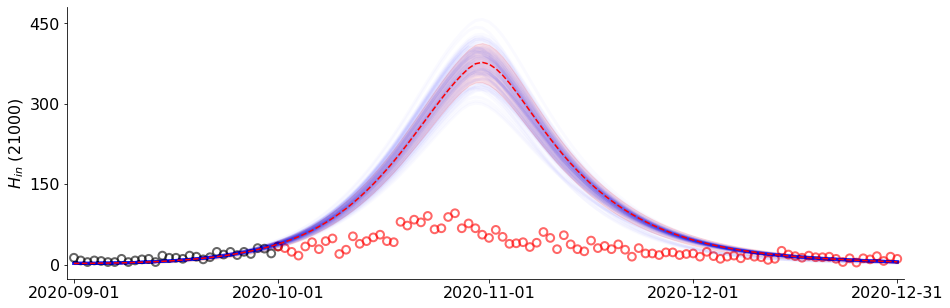

In [31]:
savename = f'../../results/calibrations/COVID19_SEIRD/arr/others/{json_name_WAVE1[:-5]}_FIT.png'
savename=None
NIS=21000
if NIS:
    savename = f'insufficient-calibration_{NIS}.png'
else:
    savename = f'insufficient-calibration_national.png'

start_calibration = samples_dict[f'start_date_{job}']
end_calibration = samples_dict[f'end_date_{job}']

fig, ax = plt.subplots(figsize=(15,5))

ax, median_draw = plot_calibration_fit(out, df_sciensano, 'H_in', start_sim, end_sim, \
            start_calibration=start_calibration, end_calibration=end_calibration, NIS=NIS, \
            savename=None, conf_int=0.05, show_all=True, ax=ax)
ax.grid(False)
ax.set_xticks([pd.to_datetime('2020-09-01'), pd.to_datetime('2020-10-01'), pd.to_datetime('2020-11-01'), \
              pd.to_datetime('2020-12-01'), pd.to_datetime('2020-12-31')])
ax.tick_params(axis='both', labelsize=16)
if NIS==None:
    ax.set_ylabel(r'$H_{in}$ (national)', fontsize=16)
else:
    ax.set_ylabel(r'$H_{in}$ ('+str(NIS)+')', fontsize=16)
# ax.set_ylim([0, 800])

subset=False
if subset:
    ax.set_xlim([pd.to_datetime('2020-09-01'), pd.to_datetime('2020-10-01')])
    ax.set_ylim(0, 200)

if savename:
    plt.savefig(savename, dpi=400, bbox_inches='tight')

**Discussion**

Possible problems/solutions:
- bad initial conditions: you can see that the hospitalisations go down before going up, which causes the need for rather high beta values. This in turn backfires when looking at far-out extrapolations. *Experiment with different initial conditions*
- Longer calibration times are needed. We have very few iterations now.
- Possibly the values from the first-wave calibration no longer correspond with the actual values (this can be inspected from a total recalibration)
- Possibly the estimated social contact and mobility matrices are not realistic for the actual valeus (this can be inspected by comparing the estimate with the actual data)